In [1]:
import sys
import os



import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotx

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

from SparseStochMat import sparse_autocov_mat

Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


In [2]:
net_heat = ContTempNetwork.load('fig3_growing_network300_temporal_heat')

In [5]:
lamdas_growing = np.logspace(-4,0,200)
lamdas_shrinking = np.logspace(-3.5,-2,200)

In [6]:
multi_res_heat = {}
for lamda in lamdas_growing:
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_heat/clustersplot/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)

    multi_res_heat[lamda] = cluster
avg_nclusters_forw_heat_growing = [np.mean([len(c) for c in \
                   multi_res_heat[lamda] if len(c)>1]) for lamda in lamdas_growing]

NVI_forw_heat_growing = [avg_norm_var_information(multi_res_heat[lamda]) for lamda in lamdas_growing]


multi_res_heat = {}
for lamda in lamdas_shrinking:
    with open(f'//scratch/tmp/180/skoove/shrinking_experiment300_temporal_heat/clustersplot/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)

    multi_res_heat[lamda] = cluster
avg_nclusters_forw_heat_shrinking = [np.mean([len(c) for c in \
                   multi_res_heat[lamda] if len(c)>1]) for lamda in lamdas_shrinking]

NVI_forw_heat_shrinking = [avg_norm_var_information(multi_res_heat[lamda]) for lamda in lamdas_shrinking]

In [7]:
def derivative(v1, v2):
    assert len(v1) == len(v2), "Error: in order to compute the numerical derivative, the two varibales need to have the same lenght."
    derivative = []
    for i, vi in enumerate(v1[1:]):
        m1 =(vi - v1[i-1])/(v2[i]-v2[i-1])
        m2 =(v1[i+1] - vi)/(v2[i+1]-v2[i])
        derivative.append((m1+m2)/2)
    return derivative

In [8]:
lamdas_vNS =  np.logspace(-3,1,200)


vNS_heat_end_growing = []
vNS_heat_end_shrinking = []
for i, lamda in enumerate(lamdas_vNS):
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_heat/vNS/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        vNS_heat_end_growing.append(S[list(S.keys())[0]][0])
        
    with open(f'//scratch/tmp/180/skoove/shrinking_experiment300_temporal_heat/vNS/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        vNS_heat_end_shrinking.append(S[list(S.keys())[0]][0])

In [9]:
S1 = vNS_heat_end_growing
S2 = vNS_heat_end_shrinking

between_lamdas_vNS =  np.linspace(-3,1,200)

Q1 = derivative(vNS_heat_end_growing, between_lamdas_vNS)
Q2 = derivative(vNS_heat_end_shrinking, between_lamdas_vNS)

In [15]:
print(Q1)
print(Q2)

[(-0.12486037477430519+8.895136534319431e-08j), -0.00527625587917995, -0.005814306758721704, -0.0064084280151652405, -0.007064625802327998, -0.007789570161321071, -0.008590670585378454, -0.0094761603085034, -0.010455190296124453, -0.011537934008800632, -0.012735704106116144, -0.014061082355473245, -0.015528064104040716, -0.017152218760725133, -0.01895086780846858, -0.020943281920184707, -0.023150898771695776, -0.02559756311559294, -0.028309790585988207, -0.03131705651366472, -0.03465211071814597, -0.03835131876274804, -0.04245502945821163, -0.04700796741815001, -0.05205964812201866, -0.05766481113341625, -0.06388386473488691, -0.07078333213915172, -0.07843628546148226, -0.08692274861255436, -0.09633004400857598, -0.10675305030486637, -0.11829432907264673, -0.13106406733702713, -0.14517977016053907, -0.16076562313216403, -0.1779514291139749, -0.19687100768894408, -0.21765993074859946, -0.24045245557370912, -0.26537751048211655, -0.2925535915795097, -0.32208244741124215, -0.3540414674821

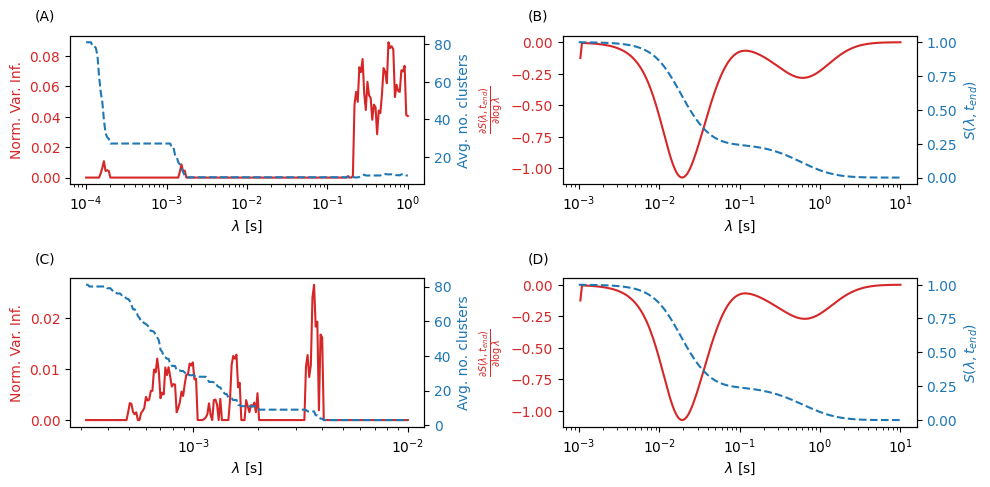

In [13]:
fig, axs = plt.subplots(2,2, sharex=False, figsize=(10, 5))

####### First Plot
color = 'tab:red'
axs[0,0].plot(lamdas_growing, NVI_forw_heat_growing, color=color, label='static norm NVI')

axs[0,0].set_xscale('log')
axs[0,0].set_xlabel(r'$\lambda$ [s]')
axs[0,0].set_ylabel('Norm. Var. Inf.', color=color)
axs[0,0].tick_params(axis='y', labelcolor=color)
axs[0,0].text(-0.1,1.1, '(A)', transform=axs[0,0].transAxes)

ax1 = axs[0,0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1.plot(lamdas_growing, avg_nclusters_forw_heat_growing, '--', color=color, label='edge-centric')

ax1.set_xlabel(r'$\lambda$ [s]')
ax1.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)

####### Second Plot

color = 'tab:red'
axs[0,1].plot(lamdas_vNS[1:], Q1, color=color, label='dvNSdt')

axs[0,1].set_xscale('log')
axs[0,1].set_xlabel(r'$\lambda$ [s]')

axs[0,1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[0,1].tick_params(axis='y', labelcolor=color)
axs[0,1].text(-0.1,1.1, '(B)', transform=axs[0,1].transAxes)

ax2 = axs[0,1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(lamdas_vNS, S1, '--', color=color, label='vNS')

ax2.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


####### Third Plot
color = 'tab:red'
axs[1,0].plot(lamdas_shrinking, NVI_forw_heat_shrinking, color=color, label='static norm NVI')

axs[1,0].set_xscale('log')
axs[1,0].set_xlabel(r'$\lambda$ [s]')
axs[1,0].set_ylabel('Norm. Var. Inf.', color=color)
axs[1,0].tick_params(axis='y', labelcolor=color)
axs[1,0].text(-0.1,1.1, '(C)', transform=axs[1,0].transAxes)

ax3 = axs[1,0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.plot(lamdas_shrinking, avg_nclusters_forw_heat_shrinking, '--', color=color, label='edge-centric')

ax3.set_xlabel(r'$\lambda$ [s]')
ax3.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor=color)

####### Fourth Plot

color = 'tab:red'
axs[1,1].plot(lamdas_vNS[1:], Q2, color=color, label='dvNSdt')

axs[1,1].set_xscale('log')
axs[1,1].set_xlabel(r'$\lambda$ [s]')

axs[1,1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[1,1].tick_params(axis='y', labelcolor=color)
axs[1,1].text(-0.1,1.1, '(D)', transform=axs[1,1].transAxes)

ax4 = axs[1,1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4.plot(lamdas_vNS, S2, '--', color=color, label='vNS')

ax4.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax4.tick_params(axis='y', labelcolor=color)


fig.tight_layout()